In [1]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set_theme(style="whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

import os
import datetime
import psycopg2
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.cm as cm
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib_venn import venn3
from itertools import combinations
import matplotlib.ticker as mticker
from dateutil.relativedelta import relativedelta
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_PORT = int(os.getenv("DB_PORT"))
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DATA_FOLDER = os.getenv("DATA_FOLDER")

In [3]:
bigbrotr = psycopg2.connect(
    host=DB_HOST,
    port=DB_PORT,
    user=DB_USER,
    password=DB_PASSWORD,
    dbname=DB_NAME
)

In [49]:
pubkey_stats = pl.read_csv(os.path.join(DATA_FOLDER, 'pubkey_stats.csv'))
pubkey_stats = pubkey_stats.with_columns([
    (pl.col("first_eventdate") * 1_000).cast(pl.Datetime("ms")).alias("first_eventdate"),
    (pl.col("last_eventdate") * 1_000).cast(pl.Datetime("ms")).alias("last_eventdate"),
    (pl.col("lifespan") * 1_000).cast(pl.Duration("ms")).alias("lifespan"),
    (pl.col("mean_interval") * 1_000).cast(pl.Duration("ms")).alias("mean_interval"),
    (pl.col("median_interval") * 1_000).cast(pl.Duration("ms")).alias("median_interval"),
    (pl.col("std_interval") * 1_000).cast(pl.Duration("ms")).alias("std_interval"),
])

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Filtro iniziale
df = pubkey_stats.filter(
    (pl.col("event_count") > 2) &
    (pl.col("first_eventdate") > pl.datetime(2022, 12, 1))
)

# 2. Conversione timestamp e durate in secondi
df = df.with_columns([
    (pl.col("first_eventdate").cast(pl.Int64) // 1_000).alias("first_eventdate_sec"),
    (pl.col("last_eventdate").cast(pl.Int64) // 1_000).alias("last_eventdate_sec"),
])

for col in ["lifespan", "mean_interval", "median_interval", "std_interval"]:
    df = df.with_columns(
        (pl.col(col).cast(pl.Int64) // 1_000).alias(f"{col}_sec")
    )

# 3. Estrazione feature e normalizzazione
features = df.select([
    "event_count",
    "first_eventdate_sec",
    "last_eventdate_sec",
    "lifespan_sec",
    "mean_interval_sec",
    "median_interval_sec",
    "std_interval_sec"
]).to_pandas()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 4. Ricerca del k ottimale
sample_size = X_scaled.shape[0] // 100
k_range = range(2, 25)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels_k = kmeans.fit_predict(X_scaled)

    inertias.append(kmeans.inertia_)
    if len(X_scaled) > sample_size:
        idx = np.random.choice(len(X_scaled), sample_size, replace=False)
        score = silhouette_score(X_scaled[idx], labels_k[idx])
    else:
        score = silhouette_score(X_scaled, labels_k)
    silhouette_scores.append(score)

# Normalizzazione e combinazione metrica
inertia_arr = np.array(inertias)
silhouette_arr = np.array(silhouette_scores)

inertia_norm = 1 - ((inertia_arr - inertia_arr.min()) / (inertia_arr.max() - inertia_arr.min()))
silhouette_norm = (silhouette_arr - silhouette_arr.min()) / (silhouette_arr.max() - silhouette_arr.min())

combined_scores = 0.5 * inertia_norm + 0.5 * silhouette_norm
best_index = np.argmax(combined_scores)
best_k = list(k_range)[best_index]

# 5. Plot: inertia + silhouette
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (SSE)', color=color1)
ax1.plot(k_range, inertias, marker='o', label='Inertia', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Asse y secondario per silhouette
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(k_range, silhouette_scores, marker='s', label='Silhouette', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Evidenzia il miglior k
ax1.axvline(best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
ax2.axvline(best_k, color='red', linestyle='--')

# Legenda unica
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Inertia and Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Clustering finale con k ottimale
best_k = 10
kmeans = KMeans(n_clusters=best_k, random_state=42)
final_labels = kmeans.fit_predict(X_scaled)

# 7. Assegna i cluster al DataFrame Polars
df = df.with_columns(pl.Series(name="cluster", values=final_labels))

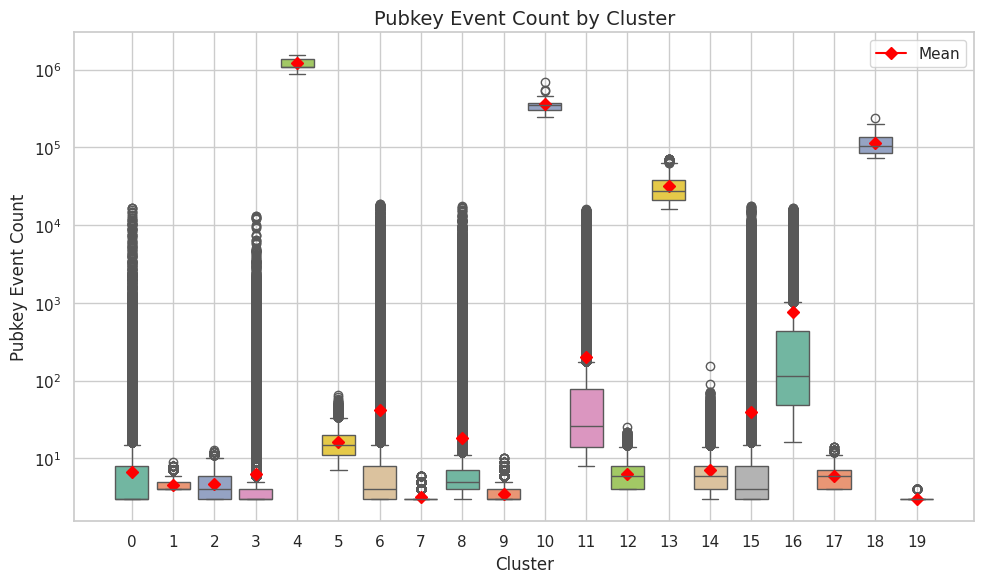

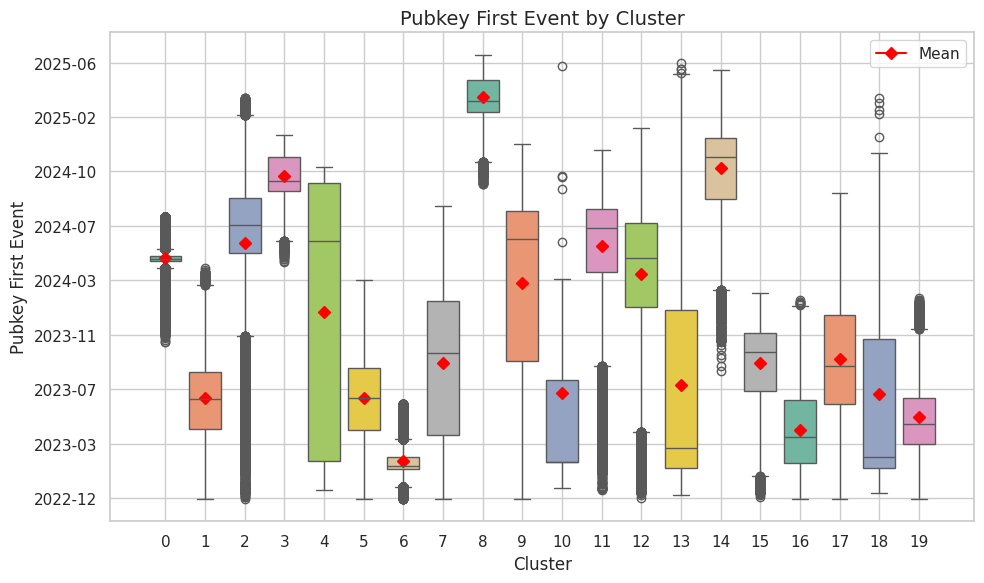

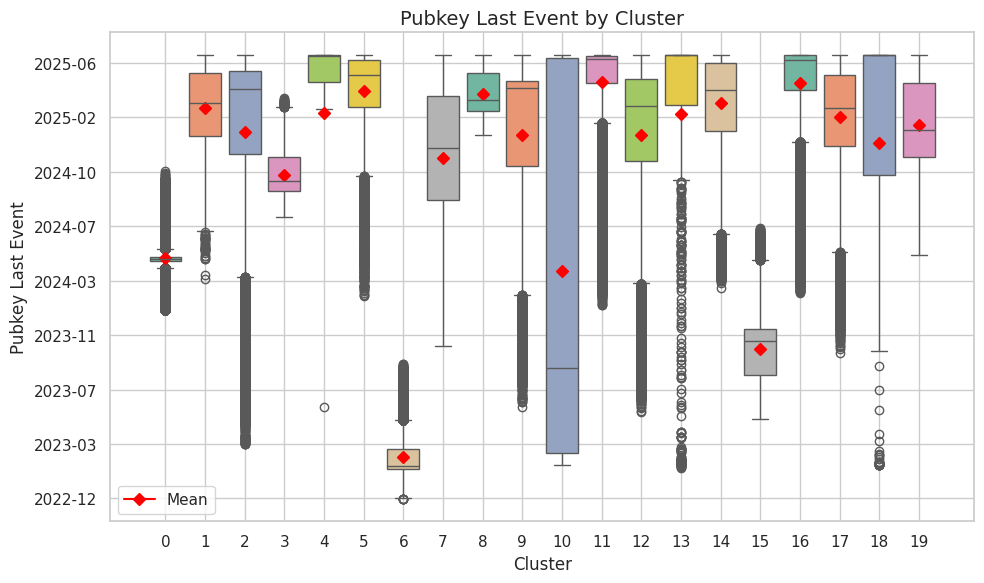

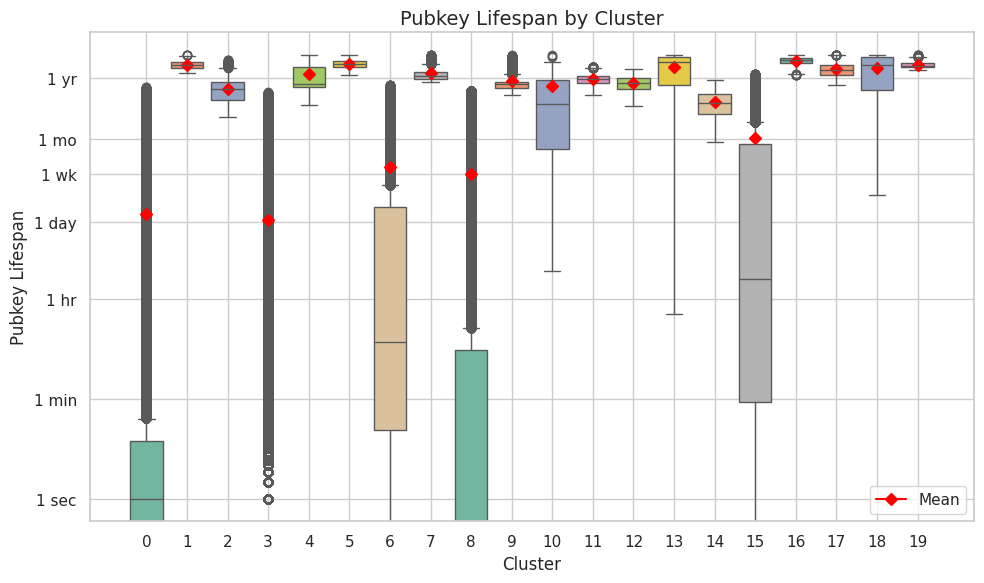

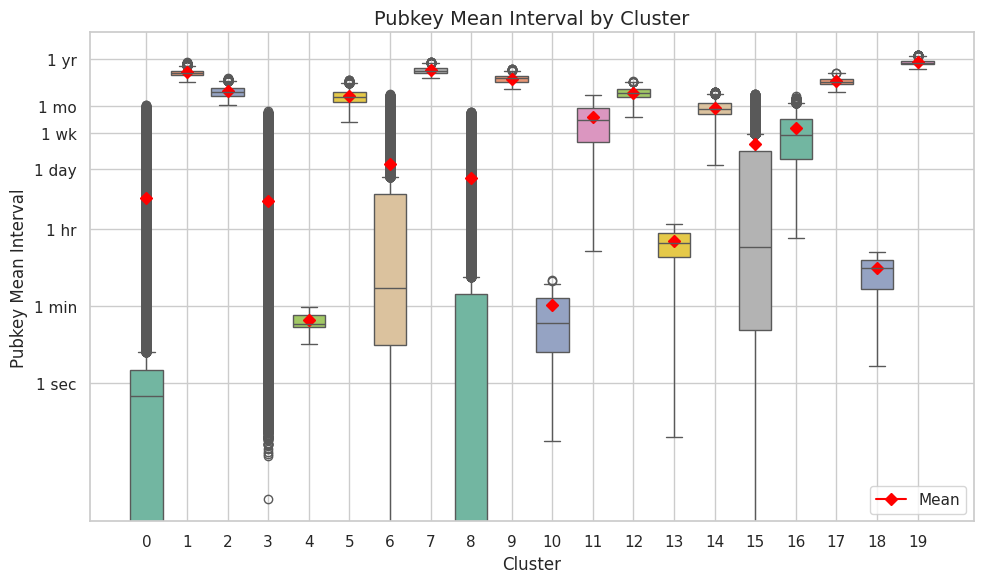

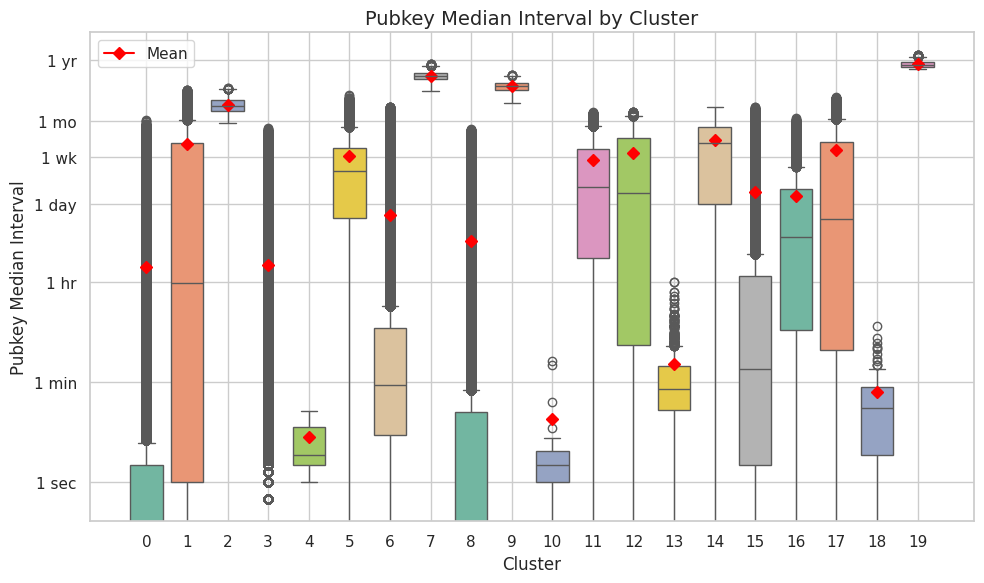

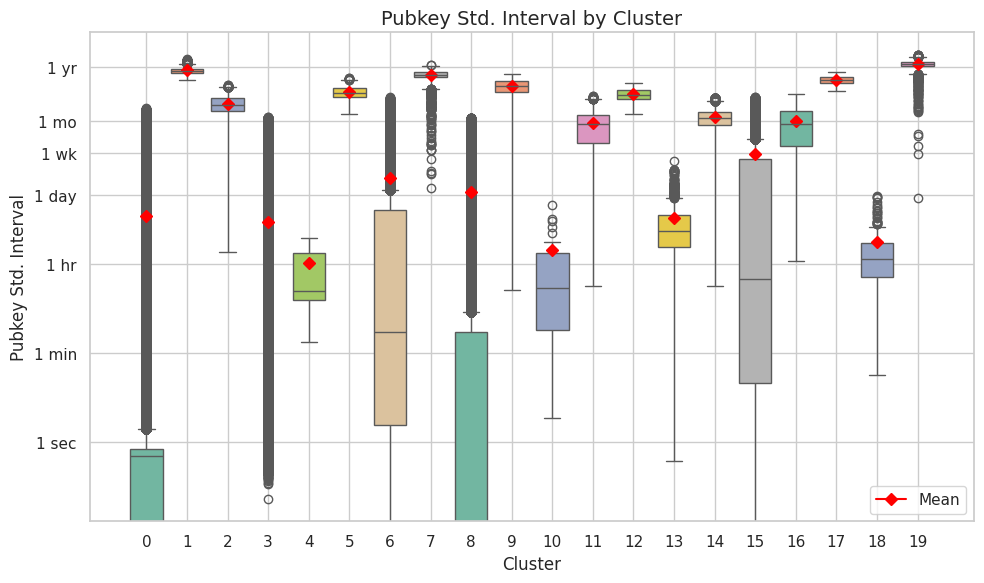

In [ ]:
# Convert to pandas
df_pd = df.to_pandas()

# Readable mapping: feature → (label, column, type)
feature_info = {
    "event_count": ("Pubkey Event Count", "event_count", "numeric"),
    "first_eventdate": ("Pubkey First Event", "first_eventdate", "datetime"),
    "last_eventdate": ("Pubkey Last Event", "last_eventdate", "datetime"),
    "lifespan": ("Pubkey Lifespan", "lifespan", "duration"),
    "mean_interval": ("Pubkey Mean Interval", "mean_interval", "duration"),
    "median_interval": ("Pubkey Median Interval", "median_interval", "duration"),
    "std_interval": ("Pubkey Std. Interval", "std_interval", "duration"),
}

# Palette for clusters
palette = sns.color_palette("Set2", n_colors=df_pd["cluster"].nunique())

# Fixed ticks in seconds and their corresponding labels for duration axis
fixed_ticks = [
    1,          # 1 second
    60,         # 1 minute
    3600,       # 1 hour
    86400,      # 1 day
    604800,     # 1 week
    2592000,    # 1 month (approx. 30 days)
    31536000,   # 1 year
]
fixed_labels = ["1 sec", "1 min", "1 hr", "1 day", "1 wk", "1 mo", "1 yr"]

def fixed_duration_formatter(x, pos):
    # Return label only if x matches a fixed tick, else empty string
    if x in fixed_ticks:
        idx = fixed_ticks.index(x)
        return fixed_labels[idx]
    else:
        return ""

# Pre-conversion: datetime and duration → seconds as float
for key, (_, col, kind) in feature_info.items():
    if kind == "datetime":
        df_pd[col + "_sec"] = df_pd[col].astype("int64") // 1_000
    elif kind == "duration":
        df_pd[col + "_sec"] = df_pd[col].dt.total_seconds()

# Plotting
for key, (label, col, kind) in feature_info.items():
    plot_col = col + "_sec" if kind in {"datetime", "duration"} else col

    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        x="cluster",
        y=plot_col,
        data=df_pd,
        palette=palette,
        showfliers=True,
        linewidth=1
    )

    # Overlay mean (red diamond) and median (blue circle)
    means = df_pd.groupby("cluster")[plot_col].mean()

    for i in range(len(means)):
        ax.plot(i, means[i], marker='D', color='red', markersize=6, label='Mean' if i == 0 else "")

    plt.title(f"{label} by Cluster", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel(label, fontsize=12)

    # Custom y-axis formatting
    if kind == "duration":
        ax.set_yscale("log")
        ax.yaxis.set_major_locator(mticker.FixedLocator(fixed_ticks))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(fixed_duration_formatter))
    elif kind == "numeric":
        ax.set_yscale("log")
    elif kind == "datetime":
        ax.yaxis.set_major_formatter(
            plt.FuncFormatter(lambda x, _: datetime.datetime.fromtimestamp(x).strftime("%Y-%m"))
        )

    plt.grid(True)
    if 'Mean' in ax.get_legend_handles_labels()[1]:
        plt.legend()
    plt.tight_layout()
    plt.show()

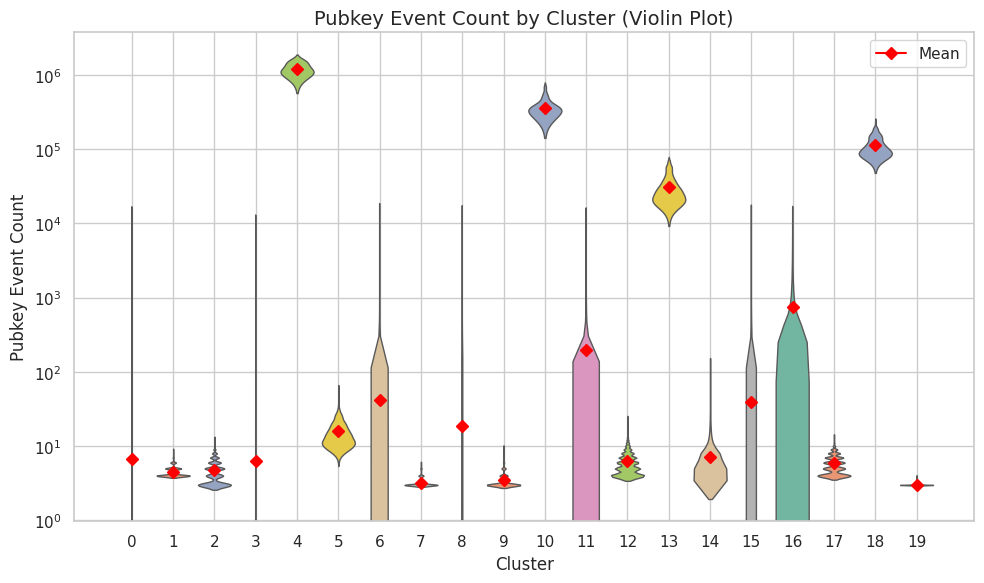

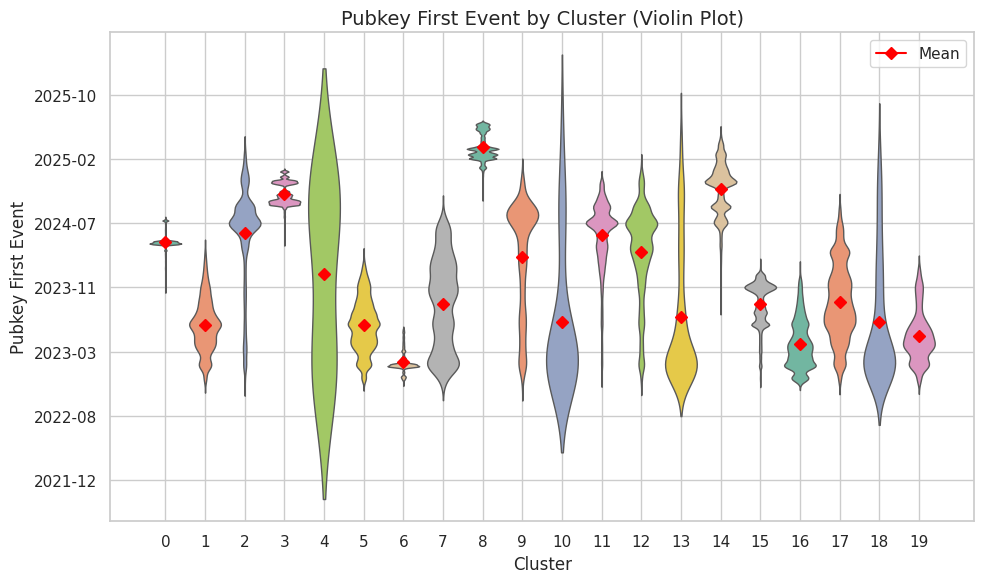

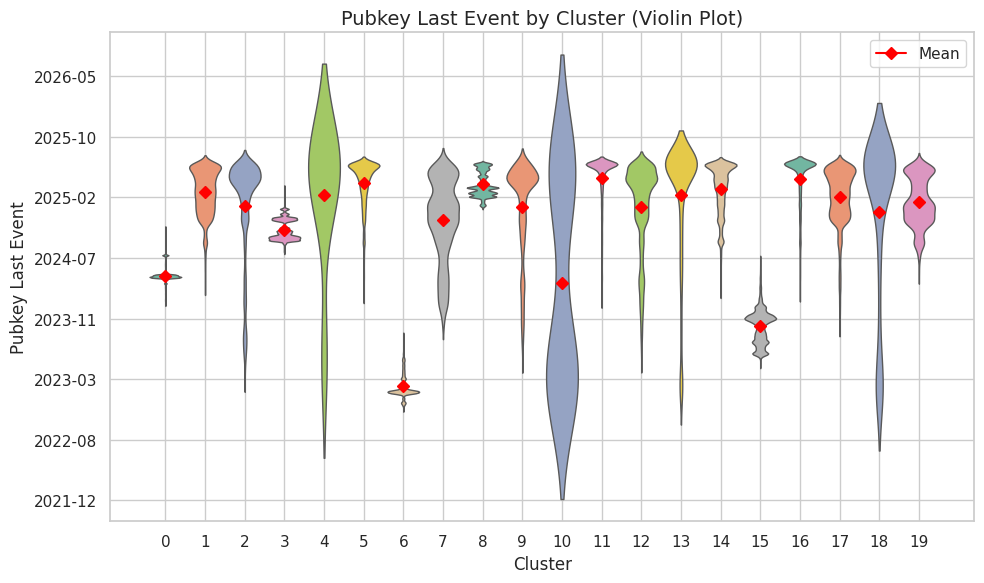

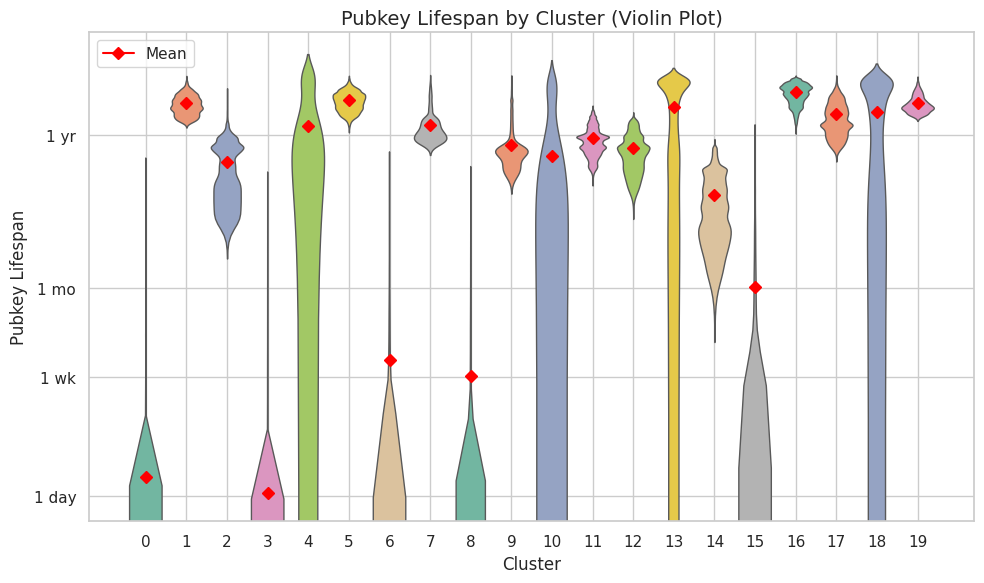

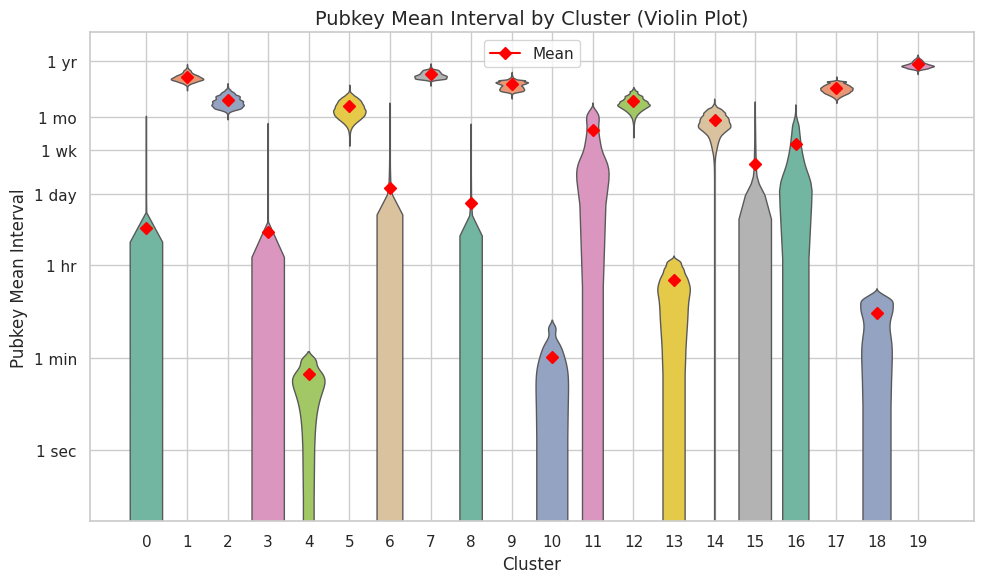

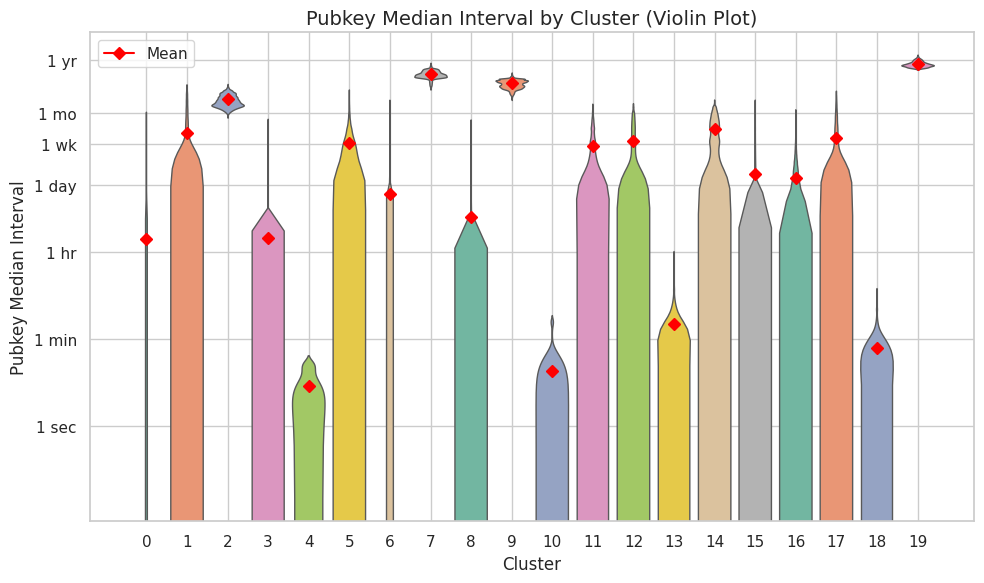

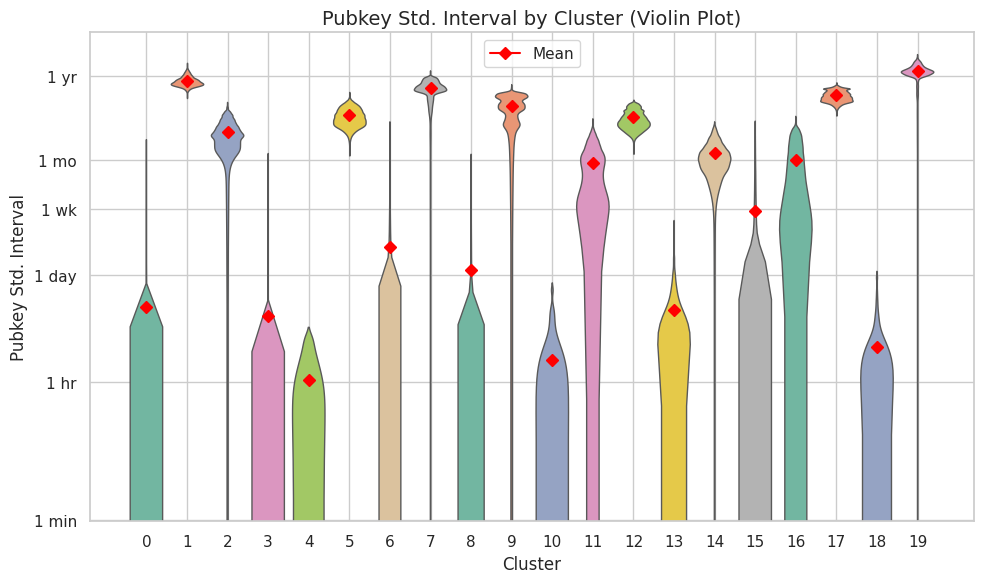

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import datetime

# Convert to pandas (già fatto)
# df_pd = df.to_pandas()

# Mapping già definito
# feature_info = {...}

# Palette per cluster
palette = sns.color_palette("Set2", n_colors=df_pd["cluster"].nunique())

# Ticks fissi per durate (già definito)
# fixed_ticks = [...]
# fixed_labels = [...]

def fixed_duration_formatter(x, pos):
    if x in fixed_ticks:
        return fixed_labels[fixed_ticks.index(x)]
    return ""

# Pre-conversione datetime/duration → seconds (già fatto, ma riassunto qui per sicurezza)
for key, (_, col, kind) in feature_info.items():
    if kind == "datetime":
        df_pd[col + "_sec"] = df_pd[col].astype("int64") // 1_000
    elif kind == "duration":
        df_pd[col + "_sec"] = df_pd[col].dt.total_seconds()

# VIOLIN PLOTS
for key, (label, col, kind) in feature_info.items():
    plot_col = col + "_sec" if kind in {"datetime", "duration"} else col

    plt.figure(figsize=(10, 6))
    ax = sns.violinplot(
        x="cluster",
        y=plot_col,
        data=df_pd,
        palette=palette,
        inner=None,  # disattiva i box interni per chiarezza
        linewidth=1
    )

    # Overlay della media (rosso) e mediana (opzionale)
    means = df_pd.groupby("cluster")[plot_col].mean()

    for i in range(len(means)):
        ax.plot(i, means[i], marker='D', color='red', markersize=6, label='Mean' if i == 0 else "")

    plt.title(f"{label} by Cluster (Violin Plot)", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel(label, fontsize=12)

    # Asse Y: scala log + formattazione
    if kind == "duration":
        ax.set_yscale("log")
        ax.yaxis.set_major_locator(mticker.FixedLocator(fixed_ticks))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(fixed_duration_formatter))
    elif kind == "numeric":
        ax.set_yscale("log")
    elif kind == "datetime":
        ax.yaxis.set_major_formatter(
            plt.FuncFormatter(lambda x, _: datetime.datetime.fromtimestamp(x).strftime("%Y-%m"))
        )

    plt.grid(True)
    if 'Mean' in ax.get_legend_handles_labels()[1]:
        plt.legend()
    plt.tight_layout()
    plt.show()

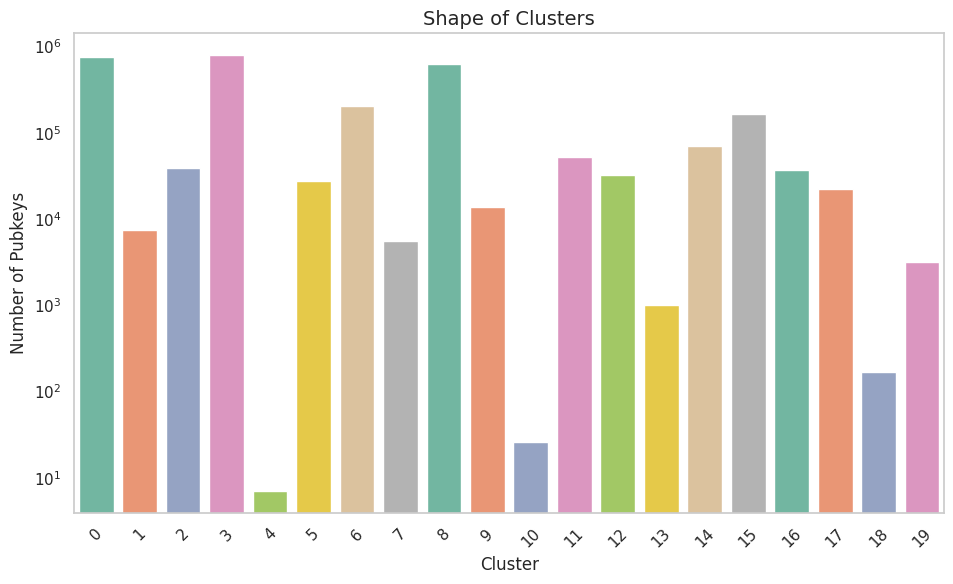

In [ ]:
# plot shape of clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df_pd, palette=palette)
plt.title('Shape of Clusters', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Pubkeys', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [55]:
bigbrotr.close()